In [1]:
%%bash
LD_LIBRARY_PATH=/nas/longleaf/rhel8/apps/cuda/lib64:$PATH:$LD_LIBRARY_PATH
export LD_LIBRARY_PATH
XLA_FLAGS=--xla_gpu_cuda_data_dir=/nas/longleaf/rhel8/apps/cuda/11.8
export XLA_FLAGS

In [2]:
import os

from xml.etree import ElementTree
import glob
from tensorflow import keras
import tensorflow as tf
import sklearn
from skimage import draw
from skimage.io import imread
from skimage import morphology
from skimage import transform
from skimage import util
import numpy as np
from matplotlib import pyplot
#from tensorflow import keras
#import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers, Model
from tensorflow.keras.utils import  plot_model
tf.keras.backend.set_image_data_format('channels_last')

2023-04-21 22:50:17.805732: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 22:50:20.941887: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nas/longleaf/apps/julia/1.6.3/lib:/nas/longleaf/rhel8/apps/cuda/11.8/lib64:/nas/longleaf/rhel8/apps/cuda/11.8/extras/CUPTI/lib64:/nas/longleaf/rhel8/apps/gcc/11.2.0/lib:/nas/longleaf/rhel8/apps/gcc/11.2.0/lib64
2023-04-21 22:50:20.943630: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
et = ElementTree.parse("proboscis_annotations_big.xml")

In [5]:
image_names = sorted(glob.glob("big/*.png"))

In [6]:
masks = {}
for img in et.findall('image'):
    width = int(img.attrib['width']) + 1
    height = int(img.attrib['height']) + 1
    blank = np.zeros(shape=(height,width),dtype=np.uint8)
    polys = img.findall('polyline')
    for poly in polys:
        attribs = poly.attrib
        pstr = attribs['points']
        pairs = pstr.split(';')
        coord_list = []
        for pair in pairs:
            xstr,ystr = pair.split(',')
            x = float(xstr)
            y = float(ystr)
            coord_list.append((x,y))
        for i in range(len(coord_list) - 1):
            start = coord_list[i]
            end = coord_list[i + 1]
            line = draw.line(round(start[1]),round(start[0]),round(end[1]),round(end[0]))
            blank[line] = np.uint8(255)
    masks[img.attrib['name']] = blank > 0

In [7]:
!pip freeze | grep 'scikit-image'

scikit-image==0.18.3


In [8]:
images = {}
for name in image_names:
    data = imread(name)
    images[name] = data

In [9]:
names = [image_name[4:] for image_name in image_names]

In [10]:
pairs = []
cross = zip(image_names, image_names)
for short_name, long_name in cross:
    if short_name in masks:
        mask = masks[short_name]
        trainee = images[long_name]
        pairs.append((trainee, morphology.dilation(mask[:-1,:-1])))
    else:
        trainee = images[long_name]
        mask = np.zeros(shape=trainee.shape)
        pairs.append((trainee, mask))

In [11]:
len(pairs)

373

In [12]:
with_probs = filter(lambda pair : pair[1].sum() > 0, pairs)

In [13]:
labeled_pairs = list(with_probs)

In [14]:
len(labeled_pairs)

350

In [15]:
inputs = []
outputs = []
for my_in, my_out in labeled_pairs:
    inputs.append(my_in)
    outputs.append(my_out)

In [16]:
ins = np.array(inputs)
outs = np.array(outputs)

In [17]:
ins.shape

(350, 600, 100)

In [18]:
outs.shape

(350, 600, 100)

In [23]:
input_data = ins[..., np.newaxis]
output_data = outs[..., np.newaxis]

In [24]:
# from https://blog.paperspace.com/unet-architecture-image-segmentation/

def convolution_block(input_lay, filters=64):
    conv1 = layers.Conv2D(filters, kernel_size=(3,3), padding="same")(input_lay)
    bn1 = layers.BatchNormalization()(conv1)
    act1 = layers.ReLU()(bn1)
    
    conv2 = layers.Conv2D(filters, kernel_size=(3,3), padding="same")(act1)
    bn2 = layers.BatchNormalization()(conv2)
    act2 = layers.ReLU()(bn2)
    
    return act2

def encoder(input_lay, filters=64):
    enc1 = convolution_block(input_lay, filters)
    max_pool1 = layers.MaxPooling2D()(enc1)
    return enc1, max_pool1

def decoder(input_lay, skip_lay, filters=64):
    upsample = layers.Conv2DTranspose(filters, (2,2), strides=2, padding="same")(input_lay)
    connect_skip = layers.Concatenate()([upsample, skip_lay])
    out = convolution_block(connect_skip, filters)
    return out

def u_net(image_size):
    input1 = layers.Input(image_size)
    
    skip1, enc1 = encoder(input1, 64)
    skip2, enc2 = encoder(enc1, 64 * 2)
    skip3, enc3 = encoder(enc2, 64 * 4)
    skip4, enc4 = encoder(enc3, 64 * 8)
    
    conv_block = convolution_block(enc4, 64*16)
    
    dec1 = decoder(conv_block, skip4, 64 * 8)
    dec2 = decoder(dec1, skip3, 64 * 4)
    dec3 = decoder(dec2, skip2, 64 * 2)
    dec4 = decoder(dec3, skip1, 64)
    
    out = layers.Conv2D(filters=1, kernel_size=(1,1), padding="same", activation="sigmoid")(dec4)
    
    model = Model(input1, out)
    
    return model

inp = layers.Input(shape=[600,100,1])
res = layers.Rescaling(1.0/255)(inp)
#x = layers.Conv2D(filters=4, kernel_size=(3,3))(res)

skip1, enc1 = encoder(res, 64)
skip2, enc2 = encoder(enc1, 64 * 2)
#skip3, enc3 = encoder(enc2, 64 * 4)

conv_block = convolution_block(enc2, 64 * 4)

dec1 = decoder(conv_block, skip2, 64 * 2)
dec2 = decoder(dec1, skip1, 64)
#dec3 = decoder(dec2, skip1, 64)

f = layers.Flatten()(dec2)

#out = layers.Dense(1)(f)
out = layers.Conv2D(filters=1, kernel_size=(1,1))(dec2)

model = Model(inp, out)
model.compile(loss=losses.BinaryCrossentropy(), optimizer=optimizers.Adam(use_ema=True))
#plot_model(model)

In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 600, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 600, 100, 1)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 600, 100, 64  640         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                            

                                )                                                                 
                                                                                                  
 batch_normalization_17 (BatchN  (None, 300, 50, 128  512        ['conv2d_18[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 re_lu_17 (ReLU)                (None, 300, 50, 128  0           ['batch_normalization_17[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 600, 100, 64  32832      ['re_lu_17[0][0]']               
 spose)                         )                                                                 
          

In [26]:
import math

class ImageSeq(keras.utils.Sequence):
    
    def __init__(self, ins: np.ndarray, outs: np.ndarray, batch=32):
        assert ins.shape == outs.shape
        self.inputs = np.copy(ins)
        self.outputs = np.copy(outs)
        self.batch = batch
    
    def __len__(self):
        return math.ceil(len(self.inputs) / self.batch)
    
    def __getitem__(self, idx):
        i = self.inputs[idx * self.batch : (idx + 1) * self.batch]
        o = self.outputs[idx * self.batch : (idx + 1) * self.batch]
        return i.astype(np.uint8), o
    

class RepeatSeq(keras.utils.Sequence):
    
    def __init__(self, wrapped, repeats :int):
        self.wrapped = wrapped
        self.repeats = repeats
    
    def __len__(self):
        return len(self.wrapped) * self.repeats
    
    def __getitem__(self, idx):
        rel_idx = idx % len(self.wrapped)
        i, o = self.wrapped[rel_idx]
        return np.copy(i), np.copy(o)
    
class RandomFlip(keras.utils.Sequence):
    
    def __init__(self, wrapped, thresh=0.4):
        self.wrapped = wrapped
        self.thresh = thresh
        self.should_flip = np.random.random(len(wrapped))
    
    def __len__(self):
        return len(self.wrapped)
    
    def __getitem__(self, idx):
        i, o = self.wrapped[idx]
        give_i = i[:]
        give_o = o[:]
        if self.should_flip[idx] > self.thresh:
            give_i = np.flip(give_i, axis=1)
            give_o = np.flip(give_o, axis=1)
        return give_i, give_o

class RandomXShift(keras.utils.Sequence):
    
    def __init__(self, wrapped, thresh=0.4):
        self.wrapped = wrapped
        self.move_likely = np.random.random(len(wrapped))
        self.thresh = thresh
        self.move_amount = np.random.randint(-20, 20, len(wrapped))
    
    def __len__(self):
        return len(self.wrapped)
    
    def __getitem__(self, idx):
        i, o = self.wrapped[idx]
        give_i = i[:]
        give_o = o[:]
        if self.move_likely[idx] > self.thresh:
            move = self.move_amount[idx]
            transl = transform.EuclideanTransform(translation=[move, 0])
            for j in range(len(give_i)):
                give_i[j] = util.img_as_ubyte(transform.warp(give_i[j], transl.inverse))
                give_o[j] = util.img_as_ubyte(transform.warp(give_o[j], transl.inverse))
        return give_i, give_o

class RandomYShift(keras.utils.Sequence):
    
    def __init__(self, wrapped, thresh=0.4):
        self.wrapped = wrapped
        self.move_likely = np.random.random(len(wrapped))
        self.thresh = thresh
        self.move_amount = np.random.randint(-200, 200, len(wrapped))
    
    def __len__(self):
        return len(self.wrapped)
    
    def __getitem__(self, idx):
        i, o = self.wrapped[idx]
        give_i = i[:]
        give_o = o[:]
        if self.move_likely[idx] > self.thresh:
            move = self.move_amount[idx]
            transl = transform.EuclideanTransform(translation=[0, move])
            for j in range(len(give_i)):
                give_i[j] = util.img_as_ubyte(transform.warp(give_i[j], transl.inverse))
                give_o[j] = util.img_as_ubyte(transform.warp(give_o[j], transl.inverse))
        return give_i, give_o

In [27]:
r = RandomXShift(RandomYShift(RandomFlip(RepeatSeq(ImageSeq(input_data, output_data, 8), 32))))

In [28]:
model.fit(r, epochs=40)

Epoch 1/40


2023-04-21 22:51:32.953478: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8801
2023-04-21 22:51:40.824985: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f3e103ead80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-21 22:51:40.825017: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB MIG 2g.10gb, Compute Capability 8.0
2023-04-21 22:51:40.877828: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-21 22:51:40.980410: W tensorflow/compiler/xla/service/gpu/nvptx_helper.cc:56] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-

1408/1408 [==============================] - 281s 186ms/step - loss: 0.0408
Epoch 2/40
1408/1408 [==============================] - 260s 184ms/step - loss: 0.0269
Epoch 3/40
1408/1408 [==============================] - 260s 184ms/step - loss: 0.0295
Epoch 4/40
1408/1408 [==============================] - 259s 184ms/step - loss: 0.0284
Epoch 5/40
1408/1408 [==============================] - 259s 184ms/step - loss: 0.0234
Epoch 6/40
1408/1408 [==============================] - 259s 184ms/step - loss: 0.0249
Epoch 7/40
1408/1408 [==============================] - 260s 184ms/step - loss: 0.0203
Epoch 8/40
1408/1408 [==============================] - 259s 184ms/step - loss: 0.0168
Epoch 9/40
1408/1408 [==============================] - 260s 184ms/step - loss: 0.0098
Epoch 10/40
1408/1408 [==============================] - 260s 185ms/step - loss: 0.0098
Epoch 11/40
1408/1408 [==============================] - 260s 184ms/step - loss: 0.0142
Epoch 12/40
1408/1408 [=============================

In [29]:
model.save("proboscis_model_1")

INFO:tensorflow:Assets written to: proboscis_model_1/assets


INFO:tensorflow:Assets written to: proboscis_model_1/assets


In [30]:
a,b = r[0]

In [31]:
m = model(a)

2023-04-22 07:29:27.146470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [32]:
n = m.numpy()

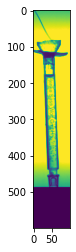

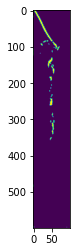

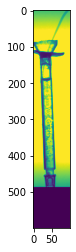

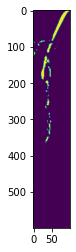

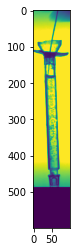

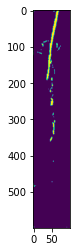

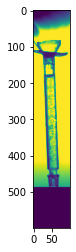

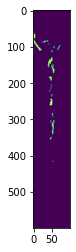

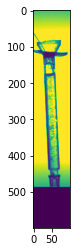

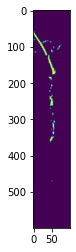

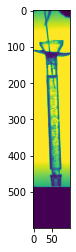

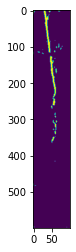

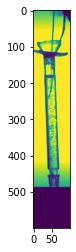

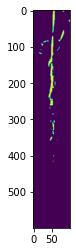

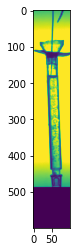

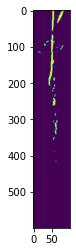

In [39]:
for i in range(8):
    pyplot.imshow(a[i,:,:,0])
    pyplot.show()
    pyplot.imshow(n[i,:,:,0] > 0)
    pyplot.show()

In [36]:
pyplot.imshow

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, *, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>